# UMAP reduction of all COI

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [ ]:
import umap
from ehv import core, load as e_load, correlation
from matplotlib import cm
import matplotlib
import statsmodels.api as sm
from sklearn.neighbors import kneighbors_graph
import scipy.spatial.distance
import scipy.sparse
from sklearn.preprocessing import scale, robust_scale, minmax_scale
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

import pyarrow.parquet as pq

In [41]:
samples = None
# samples = pandas.read_csv("data/selected_samples.csv")
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    samples, "Low/*.cif")
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

df = df[df["meta_label_coi"]]

import re
reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

In [49]:
index = numpy.load("/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/results/scip/202111011839/single_focused_index.npy", allow_pickle=True)
df = pq.read_table("/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/results/scip/202111011839/features.parquet").to_pandas().loc[index]
columns = numpy.load("/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/results/scip/202111011839/columns.npy", allow_pickle=True)
df["meta_index"] = df.index.map(lambda a: a.split("_")[1]).values
df = df[columns]

In [50]:
df = df[df["meta_label"] != "unknown"]

In [51]:
orig_df = df.copy()

In [26]:
corr = correlation.Correlation(thresh=0.7)
corr.fit(df.filter(regex="feat"))
df = corr.transform(df)

In [43]:
df[df.filter(regex="feat").columns] = minmax_scale(df.filter(regex="feat"))

In [52]:
df[df.filter(regex="feat").columns] = scale(df.filter(regex="feat"))

In [176]:
def do_minmax_scale(df):
    df[df.filter(regex="feat").columns] = minmax_scale(df.filter(regex="feat"))
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_minmax_scale)

In [177]:
def do_zscore_scale(df):
    df[df.filter(regex="feat").columns] = scale(df.filter(regex="feat"))
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_zscore_scale)

In [20]:
def do_robust_scale(df):
    df[df.filter(regex="feat").columns] = robust_scale(df.filter(regex="feat"), quantile_range=(0.05, 0.95))
    return df

df = df.groupby(["meta_timepoint"]).apply(do_robust_scale)

In [53]:
df.shape

(15512, 112)

In [42]:
def do_low_variance_filter(df):
    v = VarianceThreshold(0.01).fit(df.filter(regex="feat"))
    cols = df.filter(regex="feat").columns[v.get_support()]
    cols = cols.append(df.filter(regex="meta").columns)
    return df[cols]

df = do_low_variance_filter(df)

df.shape

(15512, 112)

## Compute UMAP on all cells of interest

In [54]:
pca = PCA(n_components=2).fit_transform(df.filter(regex="feat"))
pca.shape

df["red_pca_0"] = pca[:, 0]
df["red_pca_1"] = pca[:, 1]

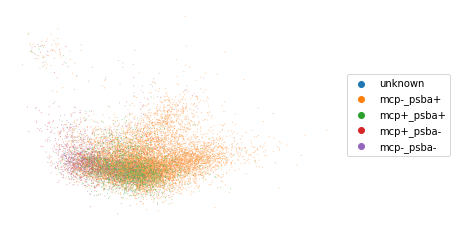

In [55]:
ax = seaborn.scatterplot(data=df, x="red_pca_0", y="red_pca_1", hue="meta_label", edgecolors="none", s=1, alpha=0.5, legend=True, hue_order=["unknown", "mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()

In [56]:
pca = PCA(n_components=0.95).fit_transform(df.filter(regex="feat"))
pca.shape

(15512, 61)

In [57]:
%%time
model = umap.UMAP(densmap=False, random_state=42, metric="cosine")
projection = model.fit_transform(pca)

CPU times: user 32.2 s, sys: 15.4 s, total: 47.6 s
Wall time: 15.2 s


In [181]:
dump(projection, "/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/%s.dat" % uuid.uuid4())

['/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/fbc5bd36-0ba8-44d0-b526-654873c0b4e0.dat']

In [33]:
projection = load("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/fbc5bd36-0ba8-44d0-b526-654873c0b4e0.dat")

In [58]:
df["red_umap_0"] = projection[:, 0]
df["red_umap_1"] = projection[:, 1]

In [66]:
df = df.reset_index(drop=True)
df["index"] = numpy.arange(len(df))
for col in df:
    if(df[col].dtype == numpy.int64):
        df[col] = df[col].astype(numpy.int32)
df.to_feather("/data/weizmann/test2.feather", compression="uncompressed")

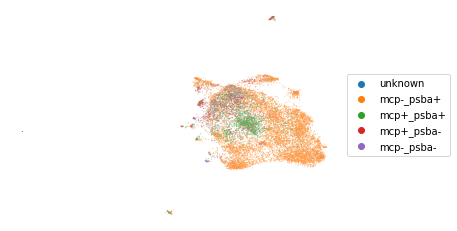

In [59]:
ax = seaborn.scatterplot(data=df, x="red_umap_0", y="red_umap_1", hue="meta_label", edgecolors="none", s=1, alpha=0.5, legend=True, hue_order=["unknown", "mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()

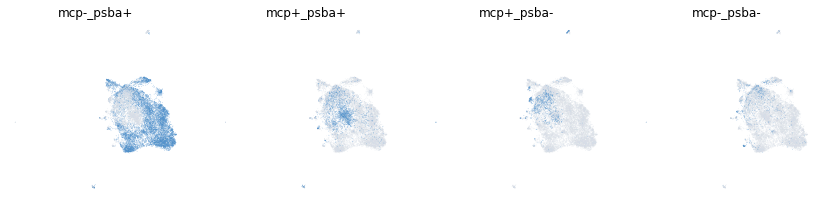

In [61]:
grid = seaborn.FacetGrid(data=df[df["meta_label"] != "unknown"].reset_index(), col="meta_label", col_order=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"])
cpal = seaborn.color_palette([(213/255, 221/255, 231/255), (29/255, 116/255,195/255)])

for col_name, ax in grid.axes_dict.items():
    ax.set_title(col_name)
    ax.set_axis_off()
    seaborn.scatterplot(data=df, x="red_umap_0", y="red_umap_1", hue=df["meta_label"]==col_name, hue_order=[False, True], s=0.5, alpha=0.5, ax=ax, legend=False, palette=cpal)

# plt.savefig("figs/faceted_states_umap.png", dpi=150)

In [28]:
import matplotlib.colors
matplotlib.colors.to_rgba("gray", alpha=0.5)

(0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.5)

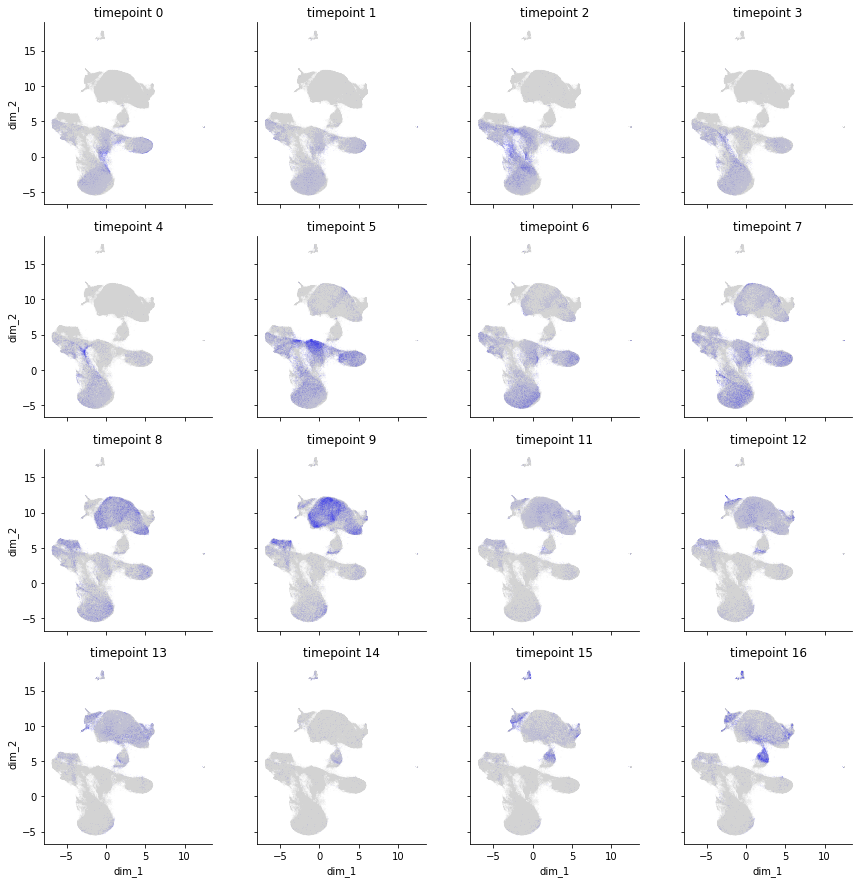

In [42]:
tmp_df = df
grid = seaborn.FacetGrid(data=tmp_df[tmp_df["meta_label"] != "unknown"].reset_index(), col_wrap=4, col="meta_timepoint", hue_order=sorted(tmp_df["meta_timepoint"].unique()))
cpal = seaborn.color_palette(["lightgray", "blue"])

for col_name, ax in grid.axes_dict.items():
    ax.set_title("timepoint " + str(col_name))
    seaborn.scatterplot(data=tmp_df, x="dim_1", y="dim_2", hue=tmp_df["meta_timepoint"]==col_name, hue_order=[False, True], s=0.1, alpha=0.5, edgecolors="none", ax=ax, legend=False, palette=cpal)
plt.savefig("figs/umap/timepoints.png", dpi=150)

In [ ]:
## export
def knn_umap_plot(df, ax, fig=None, colorbar=True, cmap="cool", metric="cosine"):
    knn = scipy.sparse.tril(kneighbors_graph(df.filter(regex="feat"), n_jobs=-1, n_neighbors=5, metric=metric)).toarray()
    dists = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(df[["dim_1", "dim_2"]], "euclidean"))
    
    norm = matplotlib.colors.Normalize(vmin=dists.min(), vmax=dists.max())
    cmap = cm.get_cmap(cmap)
    for i in range(knn.shape[0]):
        for j in knn[i].nonzero()[0]:
            xx = [df.iloc[i]["dim_1"], df.iloc[j]["dim_1"]]
            yy = [df.iloc[i]["dim_2"], df.iloc[j]["dim_2"]]
            ax.plot(xx, yy, alpha=0.2, c=cmap(norm(dists[i, j])), linewidth=.5)
            
    if colorbar:
        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

CPU times: user 51.3 s, sys: 2.48 s, total: 53.8 s
Wall time: 49.2 s


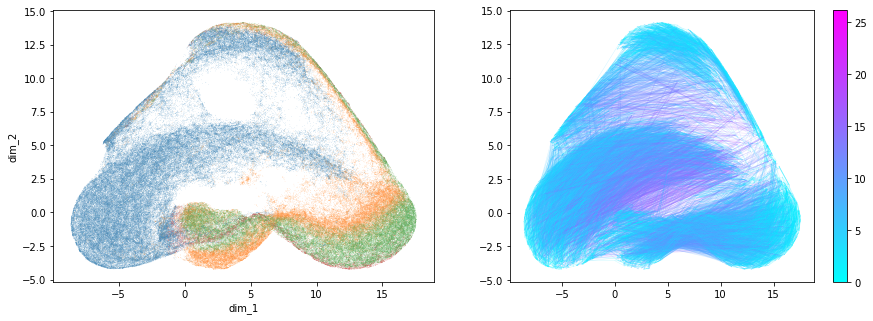

In [176]:
%%time
from sklearn.neighbors import kneighbors_graph
import scipy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
seaborn.scatterplot(data=df[df["meta_label"] != "unknown"], x="dim_1", y="dim_2", hue="meta_label", s=0.2, alpha=0.5, legend=False, ax=ax1, hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"])

sample = df.sample(n=10000)
knn_umap_plot(sample, ax2, fig, True)

In [206]:
corr = df.filter(regex="feat|dim").corr()

In [233]:
corr["dim_2"].sort_values(ascending=False)[:20]

dim_2                                      1.000000
feat_area_m04                              0.696759
feat_bright_detail_intensity_r3_mc_ch04    0.607558
feat_intensity_mc_ch04                     0.605853
feat_bright_detail_intensity_r3_mc_ch03    0.591428
feat_area_m07                              0.542752
feat_modulation_m04_ch04                   0.503950
feat_contrast_m04_ch04                     0.454906
feat_length_m07                            0.423600
feat_area_mc                               0.415710
feat_width_m06                             0.398090
feat_bright_detail_intensity_r3_mc_bf      0.388407
feat_area_m06                              0.365111
feat_median_pixel_m01_bf                   0.321882
feat_length_m06                            0.316201
feat_width_m09                             0.299521
dim_1                                      0.273358
feat_modulation_m09_bf2                    0.261211
feat_length_m09                            0.235357
feat_width_m

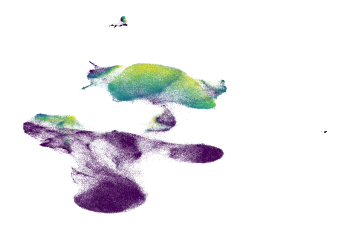

In [248]:
feat = "feat_area_m04"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)
plt.axis("off")
plt.savefig("figs/umap/feat_area_m04.png", dpi=150)

In [237]:
corr["dim_2"].sort_values(ascending=True)[:20]

feat_aspect_ratio_m11                  -0.489875
feat_gradient_rms_m07_ch7              -0.451628
feat_max_pixel_mc_ch11                 -0.447926
feat_intensity_mc_ch11                 -0.430526
feat_aspect_ratio_intensity_m11_ch11   -0.358611
feat_aspect_ratio_intensity_m07_ch7    -0.352722
feat_aspect_ratio_intensity_m01_bf     -0.332405
feat_aspect_ratio_m01                  -0.321930
feat_aspect_ratio_m09                  -0.269384
feat_aspect_ratio_intensity_m09_bf2    -0.252734
feat_median_pixel_m09_bf2              -0.246859
feat_width_m11                         -0.219806
feat_area_m11                          -0.152526
feat_contrast_m07_ch7                  -0.112643
feat_modulation_m11_ch11               -0.088789
feat_gradient_rms_m06_ssc              -0.068932
feat_gradient_rms_m01_bf                0.028659
feat_contrast_m01_bf                    0.043450
feat_max_pixel_mc_ssc                   0.062402
feat_max_pixel_mc_bf2                   0.066518
Name: dim_2, dtype: 

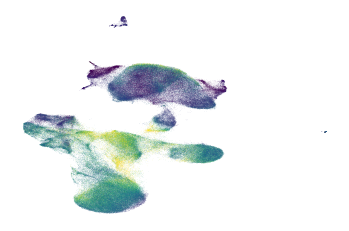

In [249]:
feat = "feat_intensity_mc_ch11"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)
plt.axis("off")
plt.savefig("figs/umap/feat_intensity_mc_ch11.png", dpi=150)

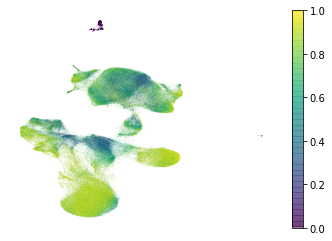

In [262]:
feat = "feat_aspect_ratio_m11"
norm = matplotlib.colors.Normalize(vmin=orig_df[feat].quantile(0), vmax=orig_df[feat].quantile(1))
plt.scatter(df["dim_1"], df["dim_2"], c=orig_df[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)
plt.colorbar()
plt.axis("off")
plt.savefig("figs/umap/feat_aspect_ratio_m11.png", dpi=150)

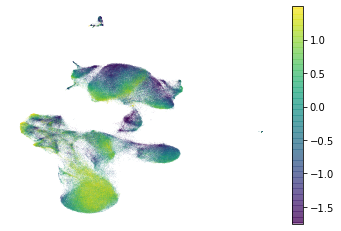

In [264]:
feat = "feat_gradient_rms_m07_ch7"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)
plt.colorbar()
plt.axis("off")
plt.savefig("figs/umap/feat_gradient_rms_m07_ch7.png", dpi=150)

In [210]:
corr["dim_1"].sort_values(ascending=False)[:20]

dim_1                                      1.000000
feat_median_pixel_m01_bf                   0.394924
feat_gradient_rms_m01_bf                   0.331951
dim_2                                      0.273358
feat_area_m04                              0.228150
feat_aspect_ratio_intensity_m01_bf         0.208752
feat_aspect_ratio_intensity_m09_bf2        0.207804
feat_median_pixel_m09_bf2                  0.176673
feat_aspect_ratio_m09                      0.170938
feat_intensity_mc_ch04                     0.170684
feat_modulation_m04_ch04                   0.124939
feat_aspect_ratio_m01                      0.124581
feat_bright_detail_intensity_r3_mc_ch04    0.113842
feat_gradient_rms_m06_ssc                  0.084674
feat_area_m07                              0.081310
feat_contrast_m04_ch04                     0.058917
feat_length_m06                            0.049754
feat_bright_detail_intensity_r3_mc_ch03    0.036940
feat_length_m07                            0.027691
feat_width_m

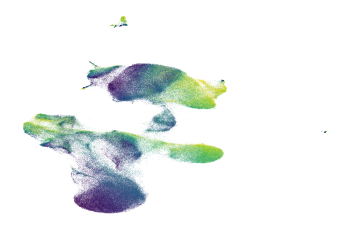

In [232]:
feat = "feat_median_pixel_m01_bf"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)
plt.axis("off")
plt.savefig("figs/umap/feat_median_pixel_m01_bf.png", dpi=300)

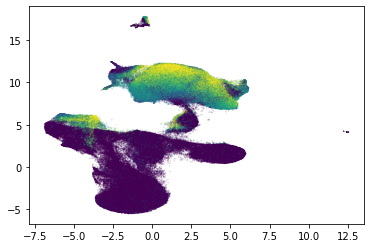

In [212]:
feat = "feat_area_m04"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.01, cmap="viridis", norm=norm)

In [213]:
corr["dim_1"].sort_values(ascending=True)[:20]

feat_max_pixel_mc_ssc                   -0.582263
feat_modulation_m01_bf                  -0.546697
feat_modulation_m06_ssc                 -0.485935
feat_intensity_mc_ssc                   -0.472959
feat_max_pixel_mc_bf2                   -0.414500
feat_max_pixel_mc_bf                    -0.402586
feat_contrast_m01_bf                    -0.377471
feat_contrast_m09_bf2                   -0.370689
feat_modulation_m09_bf2                 -0.285770
feat_gradient_rms_m07_ch7               -0.256260
feat_max_pixel_mc_ch11                  -0.208709
feat_intensity_mc_ch11                  -0.159292
feat_length_m01                         -0.149979
feat_width_m01                          -0.138073
feat_length_m09                         -0.128954
feat_contrast_m06_ssc                   -0.108029
feat_bright_detail_intensity_r3_mc_bf   -0.107066
feat_contrast_m07_ch7                   -0.104235
feat_modulation_m11_ch11                -0.086756
feat_aspect_ratio_m11                   -0.071491


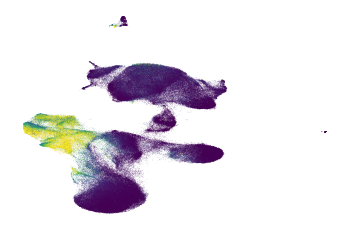

In [226]:
feat = "feat_max_pixel_mc_ssc"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.2, alpha=0.5, cmap="viridis", norm=norm, edgecolors="none")
plt.axis("off")
plt.savefig("figs/umap/feat_max_pixel_mc_ssc.png", dpi=150)